In [2]:
import os
import re
import sys
import yaml
import multiprocessing
import itertools
import logging

import pypsa

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

import matplotlib.colors as mcolors
from matplotlib.legend_handler import HandlerTuple

import cartopy.io.shapereader as shpreader
import pycountry
import cartopy.crs as ccrs

from scipy.spatial import ConvexHull

sns.set_theme(style="whitegrid")

# Replace __file__ with the absolute path of the notebook file
notebook_path = "/home/koen/research/eu-hydrogen/notebooks/scratch.ipynb"

# Insert ../scripts/ to sys.path
sys.path.insert(
    0, os.path.abspath(os.path.join(os.path.dirname(notebook_path), "..", "scripts"))
)

In [3]:
# Set font type: other we get type3 fonts which are problematic for ipe
mpl.rcParams['pdf.fonttype'] = 42

# Ignore INFO:fontTools logging messages
logging.getLogger('fontTools').setLevel(logging.WARNING)

In [4]:
config_fn = "../config/resolutions.yaml"
config = yaml.safe_load(open(config_fn))

config_default = yaml.safe_load(open("../config/config.default.yaml"))

results_dir = "../results" + (
    "/" + config["run"]["prefix"] if "prefix" in config["run"] else ""
)

scenarios_fn = config["run"]["scenarios"]["file"]
scenarios = yaml.safe_load(open(os.path.join("..", scenarios_fn)))

use_cache = True

In [5]:
titlesize = 9
textsize = 8
labelsize = 7

# cm in inch
cm = 1 / 2.54

page_width = 17.4 * cm

In [6]:
stat_names = [
    "h2prod",
    "imports",
    "system_cost",
    "obj_bound_dual",
    "h2price",
    "h2value",
    "co2seq",
    "dac",
    "captured_co2",
    "elec_cap",
    "elec_cf",
    "total_onwind",
    "total_offwind",
    "total_solar",
    "total_nuclear",
    "total_h2_storage",
    "demand:H2 for industry",
    "demand:land transport fuel cell",
    "demand:Fischer-Tropsch",
    "demand:H2 Fuel Cell",
    "demand:Haber-Bosch",
    "demand:Sabatier",
    "demand:hydrogen for highT industry",
    "demand:hydrogen for mediumT industry",
    "demand:methanolisation",
]


def stats(n: pypsa.Network):
    # H2
    i = n.links.loc[n.links.carrier.isin(["H2 Electrolysis"])].index
    MWh_h2 = -(
        n.links_t.p1.loc[:, i].sum(axis=1) * n.snapshot_weightings.generators
    ).sum()
    h2prod = (MWh_h2 / 33.33) / 1e6

    # Imports
    i = n.generators.loc[n.generators.index.str.contains("green import")].index
    imports = (
        n.generators_t.p.loc[:, i].sum(axis=1) * n.snapshot_weightings.generators
    ).sum() / 1e6

    # System cost
    system_cost = n.statistics.capex().sum() + n.statistics.opex().sum()

    # System cost bound dual
    obj_bound_dual = (
        n.global_constraints.at["total_system_cost", "mu"]
        if "total_system_cost" in n.global_constraints.index
        else np.nan
    )

    # H2 price
    h2_buses = n.buses.index[n.buses.carrier == "H2"]
    h2price = (n.buses_t.marginal_price[h2_buses].mean(axis=1) * n.snapshot_weightings.generators).sum() / 8760

    # Total value of H2 produced
    elec_i = n.links.index[n.links.carrier == "H2 Electrolysis"]
    h2value = -(
        n.snapshot_weightings.generators
        @ (
            n.links_t.p1[elec_i].rename(n.links.bus1, axis=1)
            * n.buses_t.marginal_price[n.links.bus1[elec_i]]
        )
    ).sum()

    # Total CO2 sequestration
    co2seq = n.stores.loc[n.stores.carrier == "co2 sequestered", "e_nom_opt"].sum()

    # Total amount of CO2 captured by DAC
    dac_i = n.links.loc[n.links.carrier == "DAC"].index
    dac = (
        n.links_t.p0.loc[:, dac_i].sum(axis=1) * n.snapshot_weightings.generators
    ).sum()

    # Total amount of CO2 captured, including industry, BECCS, etc.
    total = 0
    for i in [1, 2, 3, 4]:
        links_i = n.links.loc[n.links.__getattr__(f"bus{i}") == "co2 stored"].index
        co2 = n.links_t.__getattr__(f"p{i}").loc[:, links_i]
        co2 = co2.clip(upper=0)
        total -= (co2.sum(axis=1) * n.snapshot_weightings.generators).sum()

    captured_co2 = total / 1e6

    # Total installed capacity of electrolysers
    elec_cap = n.links.loc[elec_i, "p_nom_opt"].sum()

    # Mean capacity factor of electrolysers
    if elec_cap > 0:
        elec_cf = (
            n.links_t.p0.loc[:, elec_i].sum(axis=1) * n.snapshot_weightings.generators
        ).sum() / (elec_cap * n.snapshot_weightings.generators.sum())
    else:
        elec_cf = np.nan

    # Total installed onshore wind
    total_onwind = n.generators.loc[n.generators.carrier == "onwind", "p_nom_opt"].sum()

    # Total installed offshore wind
    total_offwind = n.generators.loc[
        n.generators.carrier.isin(["offwind-ac", "offwind-dc", "offwind-float"]),
        "p_nom_opt",
    ].sum()

    # Total installed solar
    total_solar = n.generators.loc[n.generators.carrier == "solar", "p_nom_opt"].sum()

    # Total installed nuclear
    nuclear_i = n.links.index[n.links.carrier == "nuclear"]
    total_nuclear = (n.links.loc[nuclear_i, "p_nom_opt"] * n.links.loc[nuclear_i, "efficiency"]).sum()

    # Total installed H2 storage
    total_h2_storage = n.stores.loc[n.stores.carrier == "H2 Store", "e_nom_opt"].sum()

    # H2 demand
    h2_balance = n.statistics.energy_balance(nice_names=False).loc[:, :, "H2"].droplevel(0, axis=0)
    h2_demand = - h2_balance.loc[h2_balance < -1e3]
    h2_demand.index = "demand:" + h2_demand.index.astype(str)

    stats = {
        "h2prod": h2prod,
        "imports": imports,
        "system_cost": system_cost,
        "obj_bound_dual": obj_bound_dual,
        "h2price": h2price,
        "h2value": h2value,
        "co2seq": co2seq,
        "dac": dac,
        "captured_co2": captured_co2,
        "elec_cap": elec_cap,
        "elec_cf": elec_cf,
        "total_onwind": total_onwind,
        "total_offwind": total_offwind,
        "total_solar": total_solar,
        "total_nuclear": total_nuclear,
        "total_h2_storage": total_h2_storage,
    } | {
        name: h2_demand[name]
        for name in h2_demand.index
    }

    for name in stat_names:
        if name not in stats:
            stats[name] = 0

    return stats

In [ ]:
if not use_cache:
    nets = {}

    # Get the overall scenario names as the top level keys in scenarios dict
    if config["run"]["name"] == "all":
        scenario_list = list(scenarios.keys())
    else:
        scenario_list = [config["run"]["name"]]

    # Assume that the following are uniquely defined for each run:
    ll = config["scenario"]["ll"][0]
    opts = config["scenario"]["opts"][0]

    # The following are taken to vary for each run.
    clusters = config["scenario"]["clusters"]
    sector_opts = config["scenario"]["sector_opts"]
    planning_horizons = config["scenario"]["planning_horizons"]
    slacks = config["scenario"]["slack"]
    senses = ["min", "max"]

    def load_stats(file):
        return (
            stats(pypsa.Network(file))
            if os.path.exists(file)
            else {v: np.nan for v in stat_names}
        )

    index = list(
        itertools.product(scenario_list, clusters, sector_opts, planning_horizons, slacks, senses)
    )
    index_opt = list(
        itertools.product(scenario_list, clusters, sector_opts, planning_horizons, [0], ["opt"])
    )

    with multiprocessing.Pool(30) as pool:
        networks = pool.map(
            load_stats,
            [
                f"{results_dir}/{s}/postnetworks/base_s_{c}_l{ll}_{opts}_{o}_{h}_{sense}{slack}.nc"
                for s, c, o, h, slack, sense in index
            ],
        )

        networks.extend(
            pool.map(
                load_stats,
                [
                    f"{results_dir}/{s}/postnetworks/base_s_{c}_l{ll}_{opts}_{o}_{h}.nc"
                    for s, c, o, h, _, _ in index_opt
                ],
            )
        )

    networks = dict(zip(index + index_opt, networks))

In [8]:
if not use_cache:
    df = pd.DataFrame(networks).T.reset_index()
    df.columns = [
        "scenario",
        "clusters",
        "opts",
        "horizon",
        "slack",
        "sense",
    ] + stat_names

    # Split the "scenario" column into "year" and "biomass"; has format "Y<year>_B<biomass_flag>"
    df[["year", "B"]] = df["scenario"].str.extract(r"Y(\d+)_B([a-z])")

    # Drop the "scenario" column
    df.drop(columns=["scenario"], inplace=True)

    # Strip any suffix of the form "-\d+seg" from the "opts" column
    # df["opts"] = df["opts"].str.replace(r"-\d+seg", "", regex=True)

    # The "opts" column has the form "XX-YY-ZZ-..."; we want to split this into
    # separate columns and keep only the last character. That is unless the
    # option as the form <int>seg, in which case we want to keep the integer
    # part and the name of the column should be "seg".
    flags = list(
        map(lambda s: "seg" if "seg" in s else s[0], df.at[0, "opts"].split("-"))
    )
    df[flags] = (
        df["opts"]
        .str.split("-", expand=True)
        .map(lambda s: int(s.strip("seg")) if "seg" in s else s[-1])
    )
    df.drop(columns=["opts"], inplace=True)

    # Add a column concatenating the year and flags
    flags_no_seg = list(filter(lambda s: s != "seg", flags))
    df["scenario"] = (
        df["year"] + df["B"] + df[flags_no_seg].apply(lambda x: "".join(x), axis=1)
    )

    # Now set the index to the scenario, year, flags, slack and horizon
    df.set_index(
        ["scenario", "year", "B"] + flags + ["clusters", "sense", "slack", "horizon"],
        inplace=True,
    )

    df.to_csv(f"cache_{results_dir.split('/')[-1]}.csv")

    display(df)
else:
    fn = f"cache_{results_dir.split('/')[-1]}.csv"
    cols = pd.read_csv(fn).columns
    df = pd.read_csv(fn, index_col=list(range(len(cols) - len(stat_names))))

    # Convert "year" index level values from int to str
    df.index = df.index.set_levels(df.index.levels[1].astype(str), level=1)

    display(df)

h2prod  \
scenario year B C I T seg  clusters sense slack horizon                 
1987baab 1987 b a a b 100  50       min   0.05  2025    -0.000000e+00   
                                    max   0.05  2025     1.079491e+01   
                                    min   0.05  2030    -0.000000e+00   
                                    max   0.05  2030     1.383552e+01   
                                    min   0.05  2035     1.606702e+00   
...                                                               ...   
1987bcab 1987 b c a b 2000 60       opt   0.00  2030     1.860749e-08   
                                                2035     3.300862e+00   
                                                2040     9.522714e+00   
                                                2045     6.715349e+00   
                                                2050     6.155929e+00   

                                                              imports  \
scenario year B C I T seg  clusters sense slack horizon                 
1987baab 1987 b a a b 100  50       min   0.05  2025     1.087010e-17   
                                    max   0.05  2025     4.903074e-08   
                                    min   0.05  2030     5.782245e-11   
                                    max   0.05  2030     9.642492e-08   
                                    min   0.05  2035     5.355139e+01   
...                                                               ...   
1987bcab 1987 b c a b 2000 60       opt   0.00  2030     6.201676e-07   
                                                2035     1.100177e+02   
                                                2040     3.173921e+02   
                                                2045     1.583209e+02   
                                                2050     2.051771e+02   

                                                          system_cost  \
scenario year B C I T seg  clusters sense slack horizon                 
1987baab 1987 b a a b 100  50       min   0.05  2025     9.713679e+11   
                                    max   0.05  2025     1.007794e+12   
                                    min   0.05  2030     9.301107e+11   
                                    max   0.05  2030     9.695430e+11   
                                    min   0.05  2035     9.852858e+11   
...                                                               ...   
1987bcab 1987 b c a b 2000 60       opt   0.00  2030     9.416609e+11   
                                                2035     9.077431e+11   
                                                2040     9.337363e+11   
                                                2045     8.444344e+11   
                                                2050     7.823837e+11   

                                                         obj_bound_dual  \
scenario year B C I T seg  clusters sense slack horizon                   
1987baab 1987 b a a b 100  50       min   0.05  2025                NaN   
                                    max   0.05  2025         -14.969405   
                                    min   0.05  2030                NaN   
                                    max   0.05  2030         -20.236593   
                                    min   0.05  2035          -3.894460   
...                                                                 ...   
1987bcab 1987 b c a b 2000 60       opt   0.00  2030                NaN   
                                                2035                NaN   
                                                2040                NaN   
                                                2045                NaN   
                                                2050                NaN   

                                                            h2price  \
scenario year B C I T seg  clusters sense slack horizon               
1987baab 1987 b a a b 100  50       min   0.05  2025      58.354703   
                        

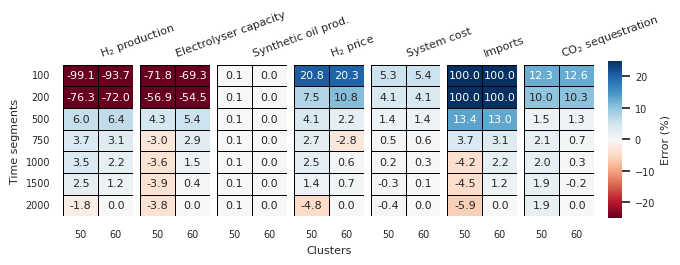

In [11]:
metrics = [
    "h2prod",
    "elec_cap",
    "demand:Fischer-Tropsch",
    "h2price",
    "system_cost",
    "imports",
    "co2seq",
]

nice_metric_names = {
    "h2prod": "H$_2$ production",
    "elec_cap": "Electrolyser capacity",
    "demand:Fischer-Tropsch": "Synthetic oil prod.",
    "h2price": "H$_2$ price",
    "system_cost": "System cost",
    "imports": "Imports",
    "co2seq": "CO$_2$ sequestration",
}

fig, axs = plt.subplots(
    ncols=len(metrics),
    nrows=1,
    figsize=(page_width, 5 * cm),
    sharey=True,
    gridspec_kw={"wspace": 0.1},
)

# Add an axis on the right side for the colorbar
cax = fig.add_axes([0.92, 0.1, 0.02, 0.8])

norm = mcolors.Normalize(vmin=-25, vmax=25)

for i, metric in enumerate(metrics):
    ax = axs[i]
    ax.set_title(metric, fontsize=titlesize)

    error_df = pd.DataFrame(
        index=df.index.get_level_values("seg").unique(),
        columns=df.index.get_level_values("clusters").unique(),
    )

    y = [2040, 2045, 2050]
    base = (2000, 60)
    for seg in error_df.index:
        for clusters in error_df.columns:
            error = (
                (
                    df.xs(base[0], level="seg").xs(base[1], level="clusters")
                    - df.xs(seg, level="seg").xs(clusters, level="clusters")
                )
                / df.xs(base[0], level="seg").xs(base[1], level="clusters")
            )[metric].copy() * 100
            error_df.at[seg, clusters] = (
                error.loc[error.index.get_level_values("horizon").isin(y)]
                .dropna()
                .sort_values(key=abs)
                # .count()
            ).iloc[-1]

    sns.heatmap(
        error_df.astype(float),
        norm=norm,
        cmap=sns.color_palette("RdBu", as_cmap=True),
        annot=True,
        fmt=".1f",
        linewidths=0.5,
        linecolor="black",
        ax=ax,
        annot_kws={"size": textsize},
        cbar=False if i < len(metrics) - 1 else True,
        cbar_kws={
            "orientation": "vertical",
            "pad": 0.2,
        },
        cbar_ax=cax,
    )

    # Set title
    ax.set_title(nice_metric_names[metric], fontsize=textsize, rotation=20, ha="left")

    # Set tick sizes on both axes
    ax.tick_params(axis="both", labelsize=labelsize)

    # Set axis labels
    ax.set_xlabel("Clusters", fontsize=textsize)
    ax.set_ylabel("Time segments", fontsize=textsize)

# Set font size on cbar
cbar = axs[-1].collections[0].colorbar
cbar.ax.tick_params(labelsize=labelsize)
cbar.set_label("Error (%)", fontsize=textsize)

# Remove all but middle x-axis titles
for i in range(len(metrics)):
    if i != len(metrics) // 2:
        axs[i].set_xlabel("")

# Remove all but bottom y-axis titles
for i in range(1, len(metrics)):
    axs[i].set_ylabel("")

# Save
fig.savefig(
    f"figures/resolution_errors.pdf",
    bbox_inches="tight",
    dpi=300,
    transparent=True,
)